In [15]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import os
import urllib
import zipfile
from pathlib import Path
import math
from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

In [16]:
# Data paths
data_path_signal = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_Avg1-3_no_clipping")
data_path_obs = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\dump\rec\timelapses_gathered")

# Choose parameters
noise_level = 3# "all",list of int, or int
clean = "n2v" # "n2v" or "avg"
display = True # display images and histograms or not
hist_bins = 512
clip = -3 # False or clip value
registration = False

# Saving dir parameters
if isinstance(noise_level,list):
    noise_level_str = ''.join(str(noise_level).split(', '))[1:-1]
else:
    noise_level_str = noise_level
noiseModelsDir = r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models"
nameHistNoiseModel = f"Hist_Noise{noise_level_str}_Sig{clean.upper()}_Clip{clip}"
nameGMMNoiseModel = f"GMM_Noise{noise_level_str}_Sig{clean.upper()}_Clip{clip}"

print(f"Noise level: {noise_level}")
print(f"Clean: {clean}")

print(f"Saving at: {noiseModelsDir}")
print(f"Histogram based noise model saving name: {nameHistNoiseModel}")
print(f"GMM based noise model saving name: {nameGMMNoiseModel}")

signal = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

if isinstance(noise_level,list) or noise_level == "all":
    mltplNoise = True
else:
    mltplNoise = False

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    
    # n2v or avg signal selection
    if clean == "avg":
        im_signal = imread(data_path_signal / file_signal)[0]
    elif clean == "n2v":
        im_signal = imread(data_path_signal / file_signal)[1]
    
    # noise level selection
    if noise_level == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(noise_level,int) or isinstance(noise_level,list):

        try:
            im_obs = imread(data_path_obs / file_obs)[noise_level]
        except IndexError:
            print(f"Image {file_obs} ignored because of IndexError") 
            continue

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    if registration:
        if mltplNoise:
            print("Registration not available for multiple noise level")
        else:
            tf = StackReg.TRANSLATION
            sr = StackReg(tf)
            tmat = sr.register(ref=im_signal,mov=im_obs)
            tform = AffineTransform(matrix=tmat)
            im_obs = warp(im_obs, tform,order=0)

    observation.append(im_obs)
    signal.append(im_signal)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

observation = np.stack(observation)
signal = np.stack(signal)

# reshape im mltpl noise case
if mltplNoise:
    nNoise = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
    signal = np.repeat(signal,nNoise,axis=0)

# signal = (signal - np.mean(signal))/np.std(signal)
# if mltplNoise:
#     for noise in range(nNoise):
#         observation[noise::nNoise] = (observation[noise::nNoise] - np.mean(observation[noise::nNoise]))/np.std(observation[noise::nNoise])
# else:
#     observation = (observation - np.mean(observation))/np.std(observation)


# Normalize the signal range to the observation range
if mltplNoise:
    signal = (signal - np.mean(signal))/np.std(signal)
    for noise in range(nNoise):
        signal[noise::nNoise] = signal[noise::nNoise] * np.std(observation[noise::nNoise]) + np.mean(observation[noise::nNoise])
else:
    signal = (signal - np.mean(signal))/np.std(signal)
    signal = signal * np.std(observation) + np.mean(observation)

signalnorm = (signal - np.mean(observation)) / np.std(observation)
observationnorm = (observation - np.mean(observation)) / np.std(observation)

minVal = np.min(signal)
maxVal = np.max(signal)

minValnorm = np.min(signalnorm)
maxValnorm = np.max(signalnorm)

print(f"\n\nConcatenated arrays:\tSignal: {signal.shape}\tObservation: {observation.shape}")


Noise level: 3
Clean: n2v
Saving at: E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models
Histogram based noise model saving name: Hist_Noise3_SigN2V_Clip-3
GMM based noise model saving name: GMM_Noise3_SigN2V_Clip-3

Found 25 files.

Signal img_and_denoised_00.tiff:	Observation rec_c01_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_01.tiff:	Observation rec_c02_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_02.tiff:	Observation rec_c03_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_03.tiff:	Observation rec_c04_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_04.tiff:	Observation rec_c05_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_05.tiff:	Observation rec_c07_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_06.tiff:	Observation rec_c08_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_07.tiff:	Observation rec_c09_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_08.tiff:	Observation rec_c10_rec_

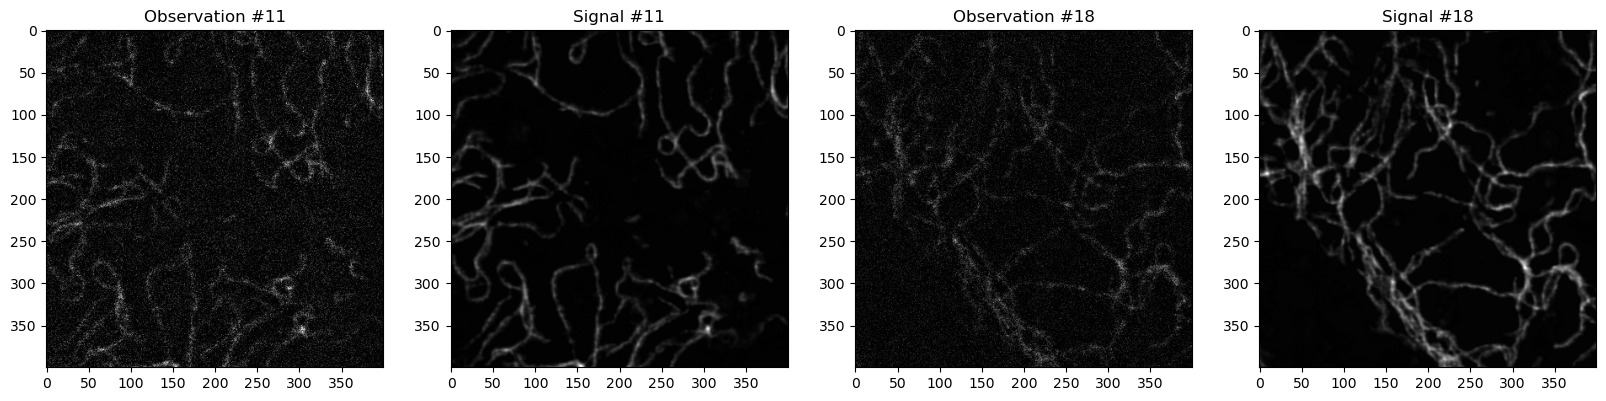

In [17]:
# Display examples of signals and observations if display is set to True

crop_size = 400
h,w = signal[0].shape

starty,startx = h//2-crop_size//2, w//2-crop_size//2
stopy,stopx = h//2+crop_size//2,w//2+crop_size//2

if display:
    idxs = np.random.randint(0,observation.shape[0],2)
    plt.figure(figsize=(20,10))
    for i in range(len(idxs)):
        sig = signal[idxs[i],starty:stopy,starty:stopy]
        obs = observation[idxs[i],starty:stopy,starty:stopy]
        plt.subplot(1,4,2*i+1)
        plt.imshow(obs,cmap="gray")
        plt.title(f"Observation #{idxs[i]}")
        plt.subplot(1,4,2*i+2)
        plt.imshow(sig,cmap="gray")
        plt.title(f"Signal #{idxs[i]}")

In [ ]:
if mltplNoise and display:
    n_impersnr = observation.shape[0] // nNoise
    idx = np.random.randint(0,n_impersnr)
    print(idx)
    plt.figure(figsize=(20,10))
    for i in range(nNoise):
        sig = signal[idx * nNoise + i,starty:stopy,starty:stopy]
        obs = observation[idx * nNoise + i,starty:stopy,starty:stopy]
        plt.subplot(2,nNoise,i+1)
        plt.imshow(obs,cmap="gray")
        plt.title(f"Observation")
        plt.subplot(2,nNoise,i+nNoise+1)
        plt.imshow(sig,cmap="gray")
        plt.title(f"Signal")
    plt.show()

In [ ]:
if mltplNoise:
    pwr = 0.1
    n_impersnr = observation.shape[0] // nNoise
    assert n_impersnr * nNoise == signal.shape[0]

    plt.figure(figsize=(15,15))
    for i in range(0,nNoise):
        histogram = histNoiseModel.createHistogram(256, minValnorm, maxValnorm, observationnorm[i::nNoise],signalnorm[i::nNoise])
        plt.subplot(math.ceil(nNoise/2),2,i+1)
        plt.title(f"SNR {i}: images {i*n_impersnr} - {(i+1)*n_impersnr} ")
        plt.axline(xy1=(0,0),slope=1,color="red",linestyle="--",linewidth=1)
        plt.imshow(histogram[0]**pwr,cmap='gray')


    plt.show()

Hist noise model saved at E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models\Hist_Noise3_SigN2V_Clip-3


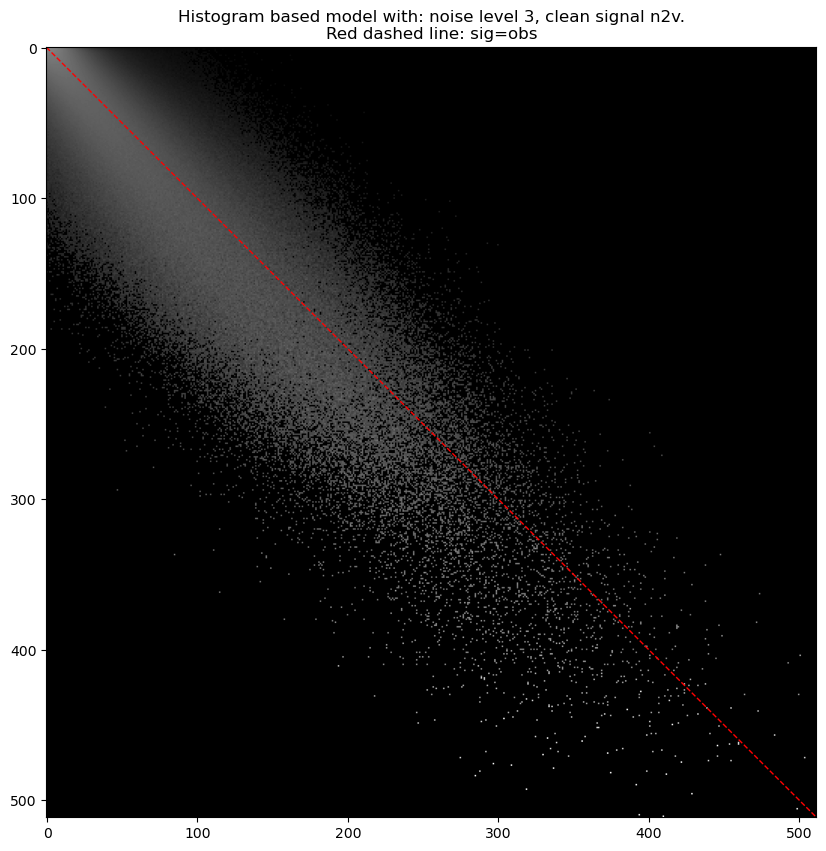

In [18]:
# Create, save and display histogram-based model

plt.figure(figsize=(10,10))
histogram = histNoiseModel.createHistogram(hist_bins, minValnorm, maxValnorm, observationnorm,signalnorm)

# Saving histogram
save_path = os.path.join(noiseModelsDir, nameHistNoiseModel)
np.save(save_path, histogram)
print(f"Hist noise model saved at {save_path}")

# Optional display
if display:
    plt.title(f"Histogram based model with: noise level {noise_level}, clean signal {clean}.\nRed dashed line: sig=obs")
    plt.imshow(histogram[0]**0.25, cmap='gray')
    plt.axline(xy1=(0,0),slope=1,color="red",linestyle="--",linewidth=1)
    plt.show()


In [19]:
# Training GMM noise model
n_gaussian = 5# Number of gaussians to use for Gaussian Mixture Model
n_coeff = 6# No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.
fullnameGMMNoiseModel = f"/{nameGMMNoiseModel}_nGauss{n_gaussian}_nCoeff{n_coeff}"

gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = minValnorm,
                                                    max_signal = maxValnorm,
                                                    path=str(noiseModelsDir), weight = None, 
                                                    n_gaussian = n_gaussian,
                                                    n_coeff = n_coeff,
                                                    min_sigma = 1, 
                                                    device = device)

gaussianMixtureNoiseModel.train(signalnorm, observationnorm, batchSize = 250000, n_epochs =3000, learning_rate=0.05, name = fullnameGMMNoiseModel,lowerClip=0)

Starting with loss = 1.7098480463027954
0 1.7098480463027954
Epoch 1: saved with loss 1.674200177192688
Epoch 2: saved with loss 1.639373779296875
Epoch 3: saved with loss 1.6056439876556396
Epoch 4: saved with loss 1.572255253791809
Epoch 5: saved with loss 1.5396777391433716
Epoch 6: saved with loss 1.508445382118225
Epoch 7: saved with loss 1.4782161712646484
Epoch 8: saved with loss 1.4481085538864136
Epoch 9: saved with loss 1.4213968515396118
Epoch 10: saved with loss 1.3937363624572754
Epoch 11: saved with loss 1.3696564435958862
Epoch 12: saved with loss 1.3434964418411255
Epoch 13: saved with loss 1.319647192955017
Epoch 14: saved with loss 1.299631953239441
Epoch 15: saved with loss 1.2791277170181274
Epoch 16: saved with loss 1.2594717741012573
Epoch 17: saved with loss 1.244060754776001
Epoch 18: saved with loss 1.2275364398956299
Epoch 19: saved with loss 1.2130892276763916
Epoch 20: saved with loss 1.201395034790039
Epoch 21: saved with loss 1.1898646354675293
Epoch 22: s

In [ ]:
# gaussianMixtureNoiseModel.weight

In [22]:
minValnorm,maxValnorm

(-0.39920184, 34.899574)

GMM_Noise3_SigN2V_Clip-3_nGauss5_nCoeff6.npz


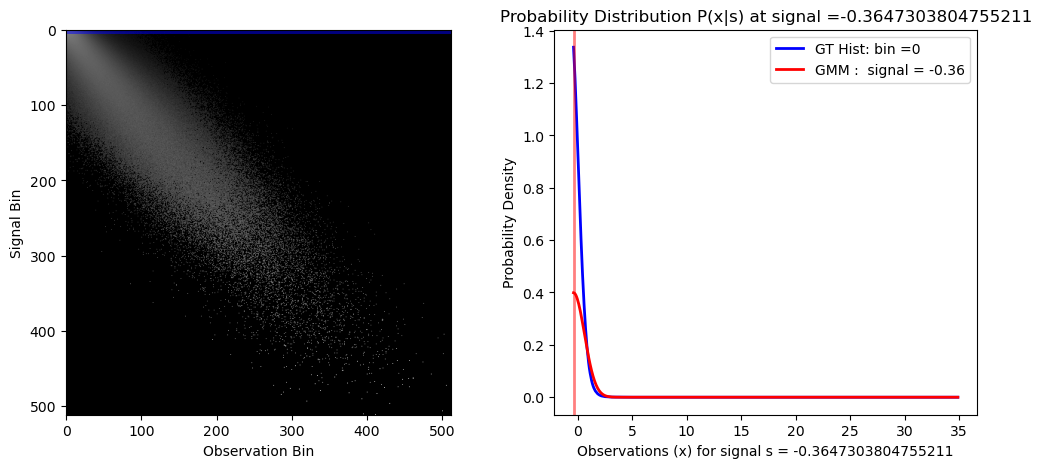

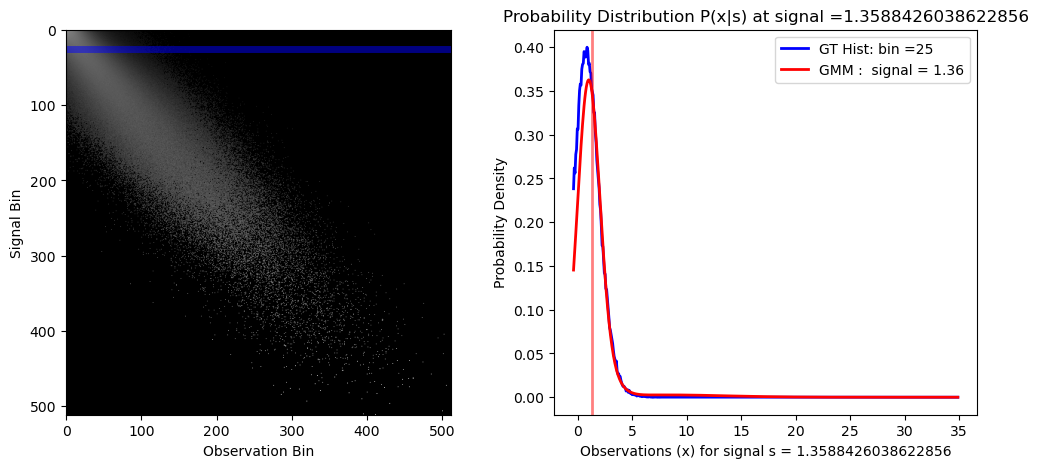

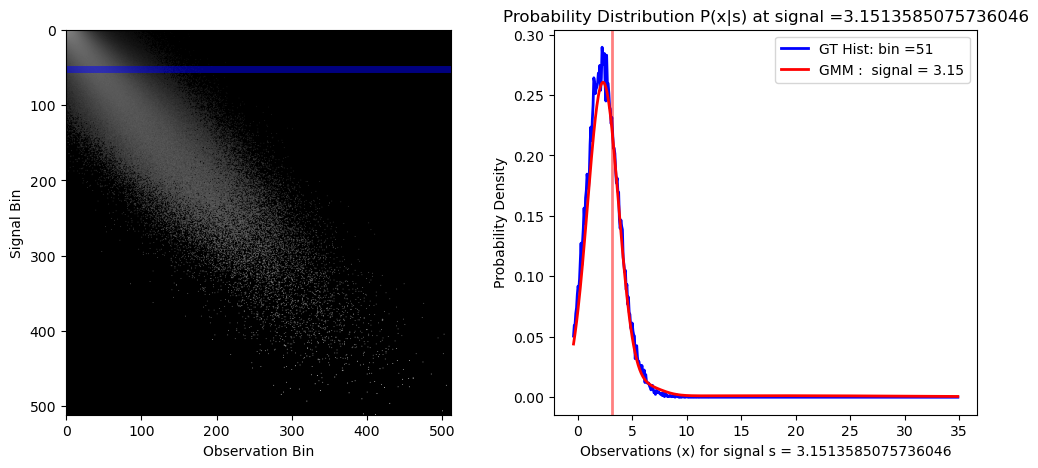

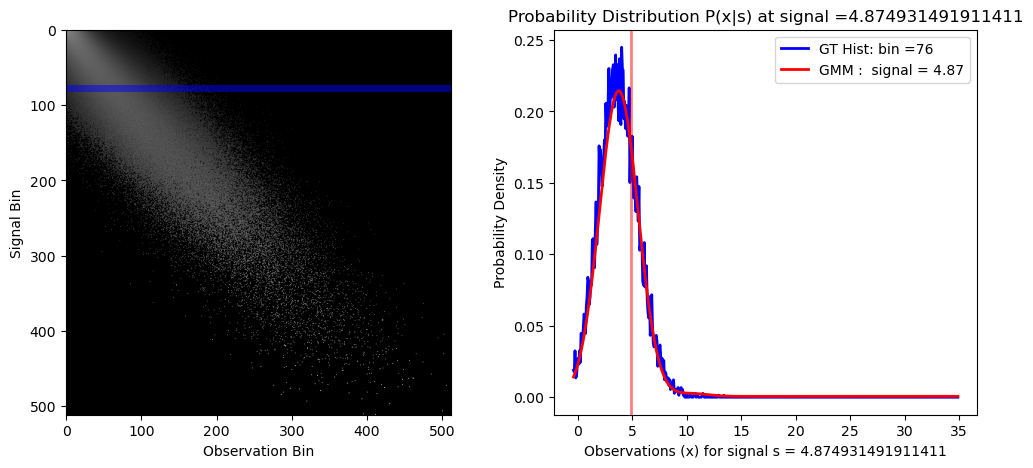

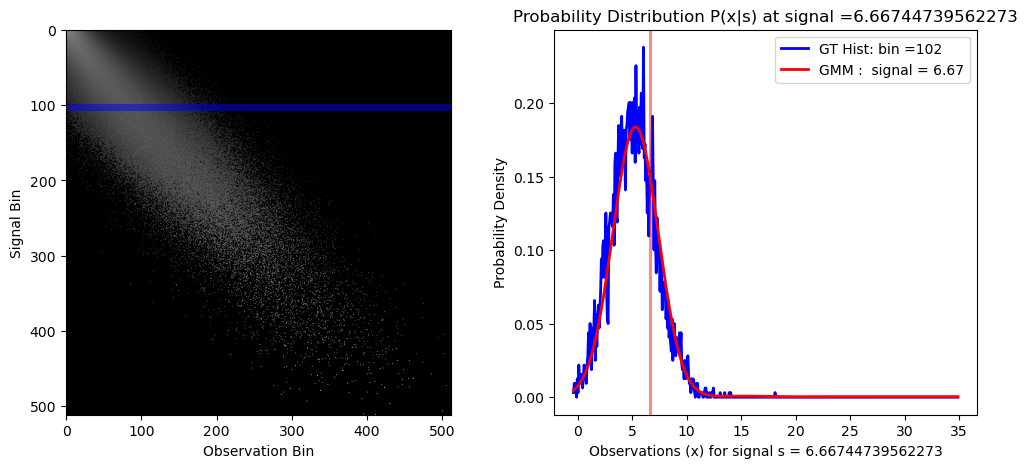

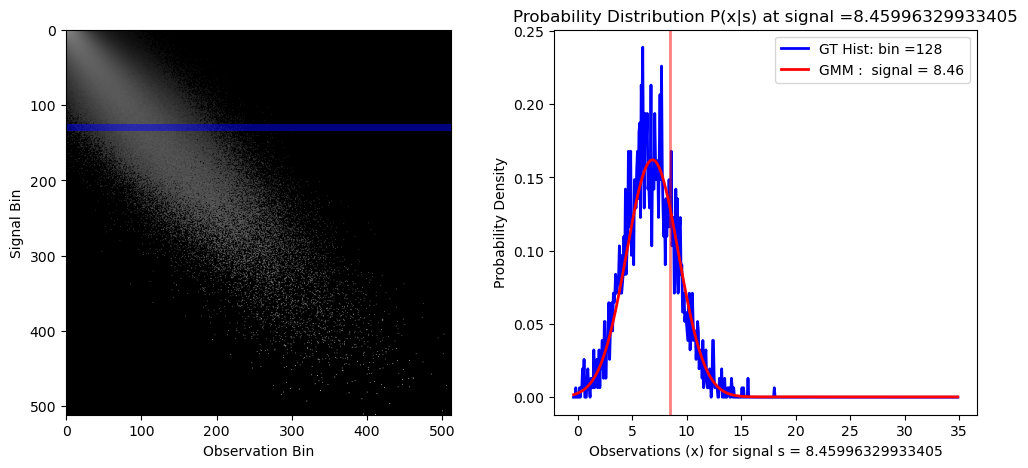

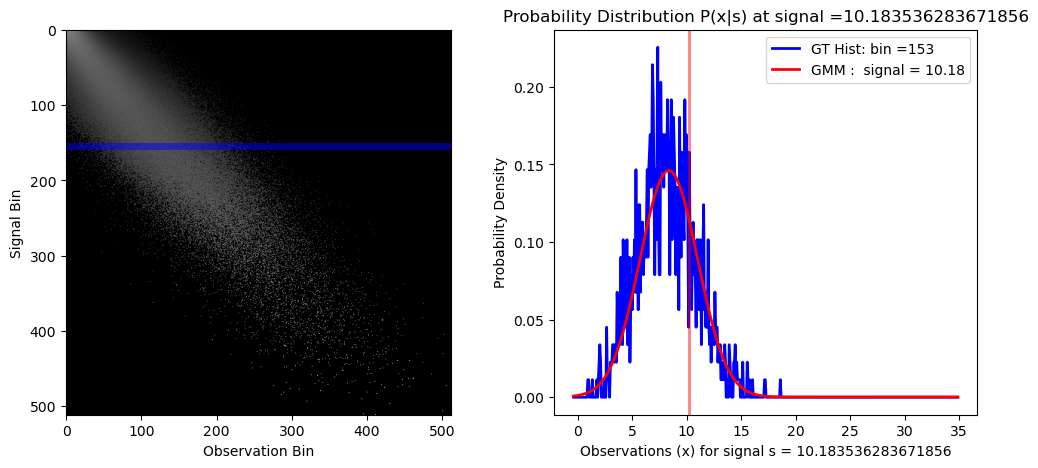

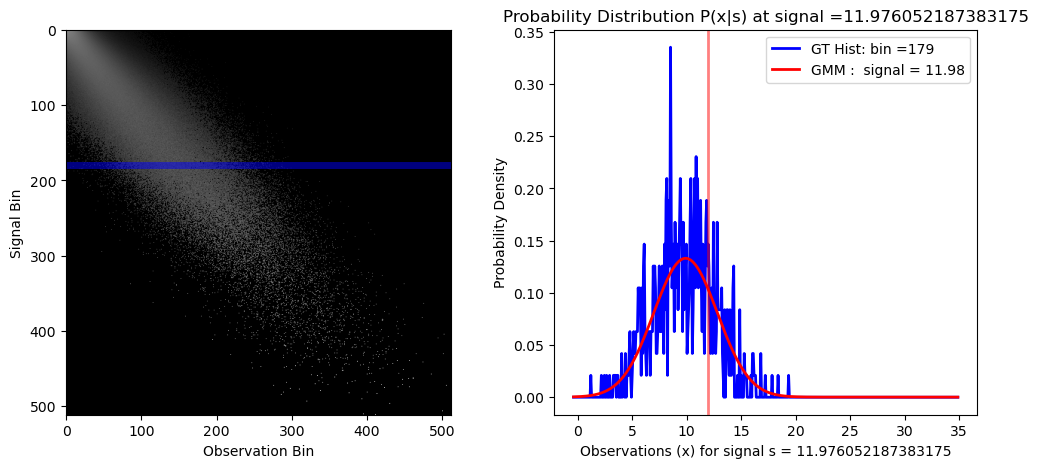

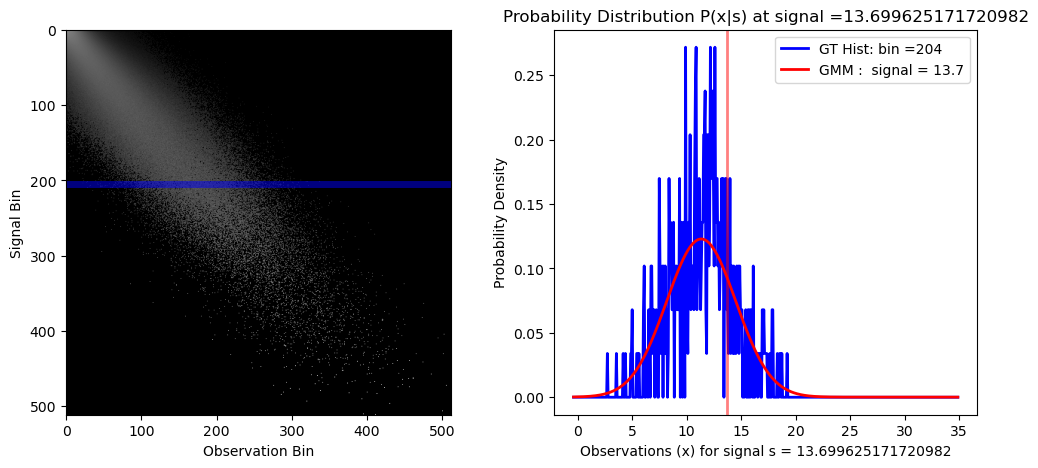

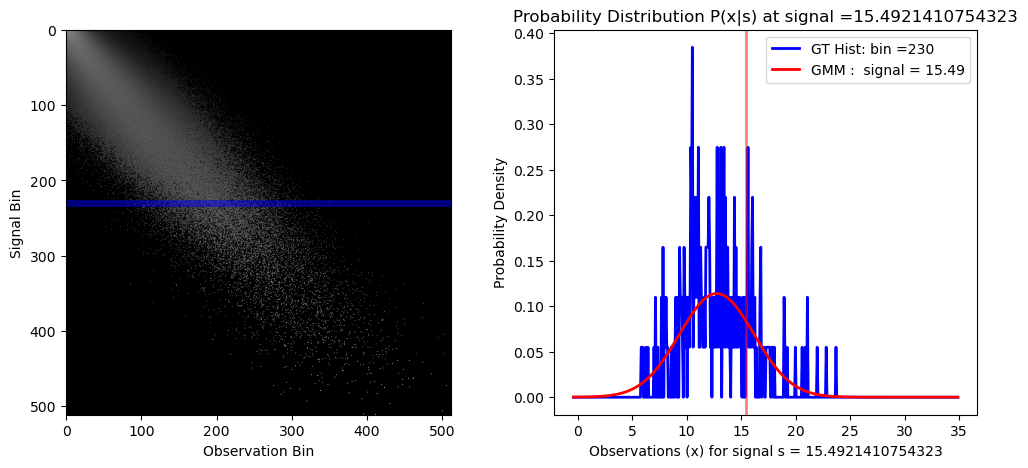

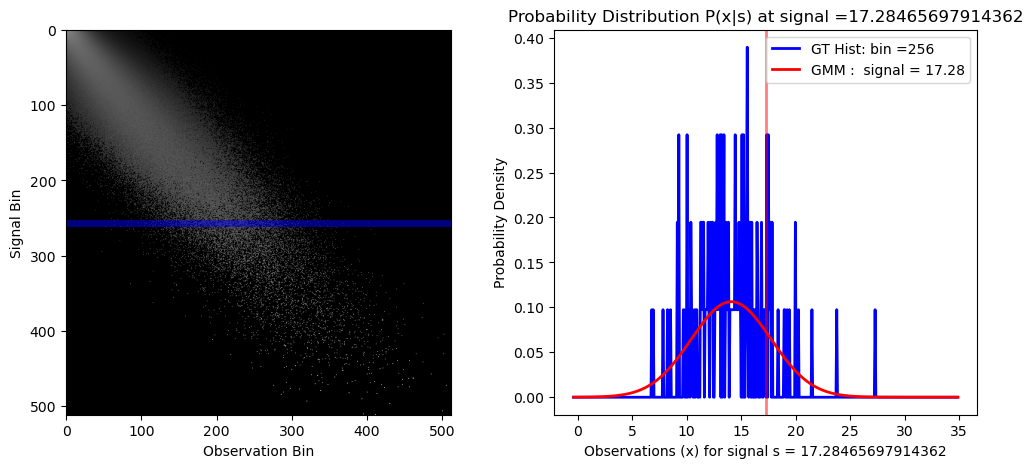

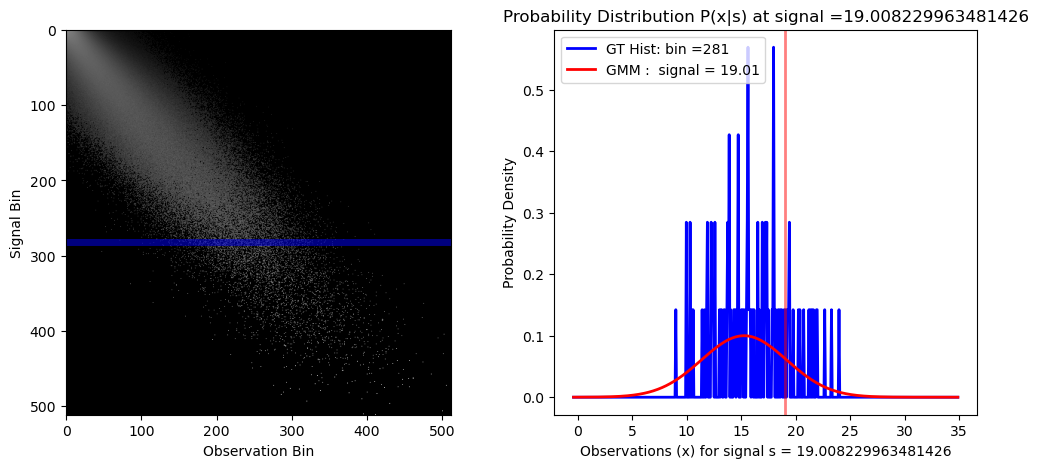

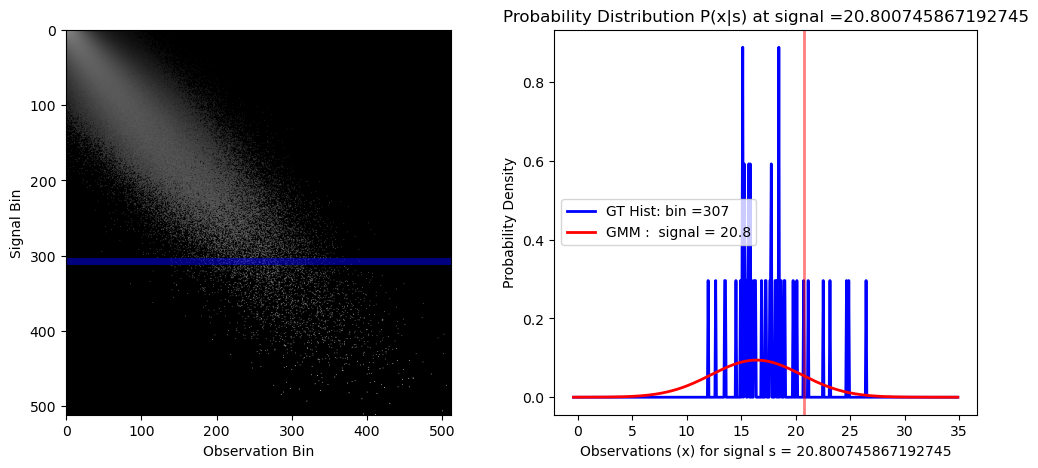

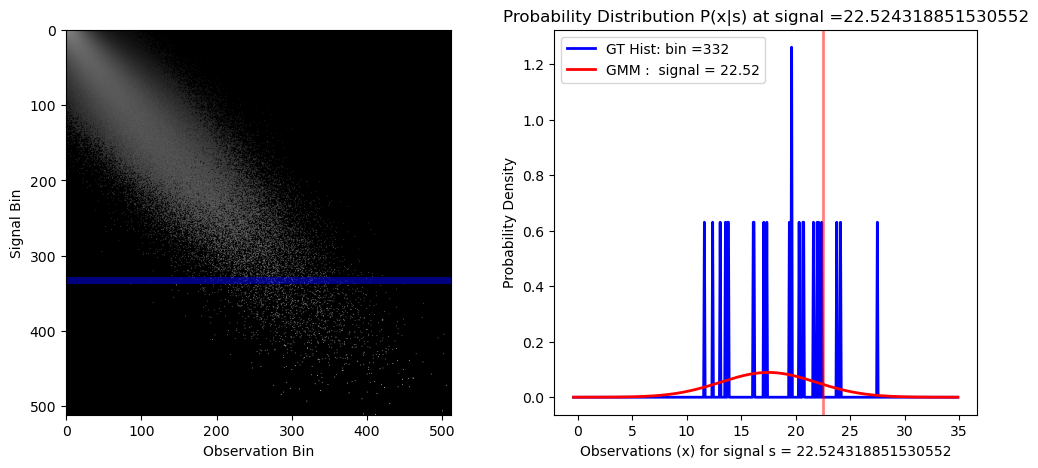

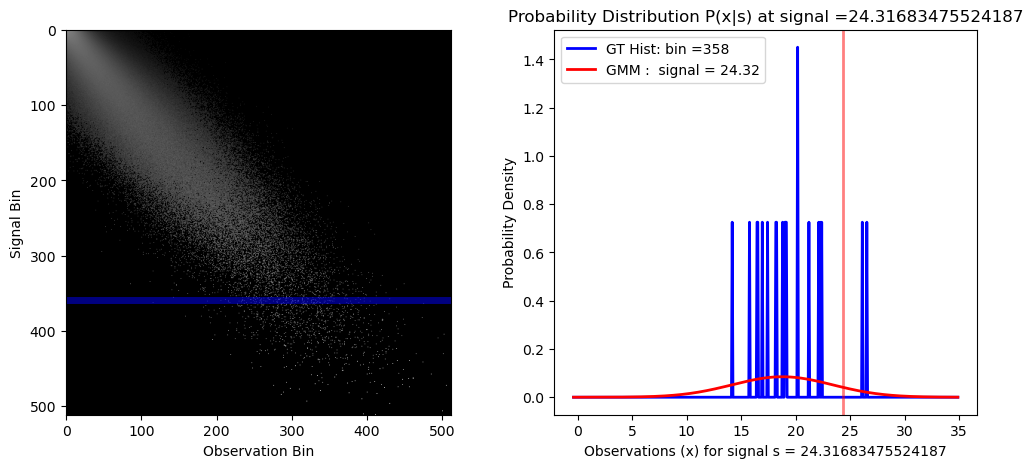

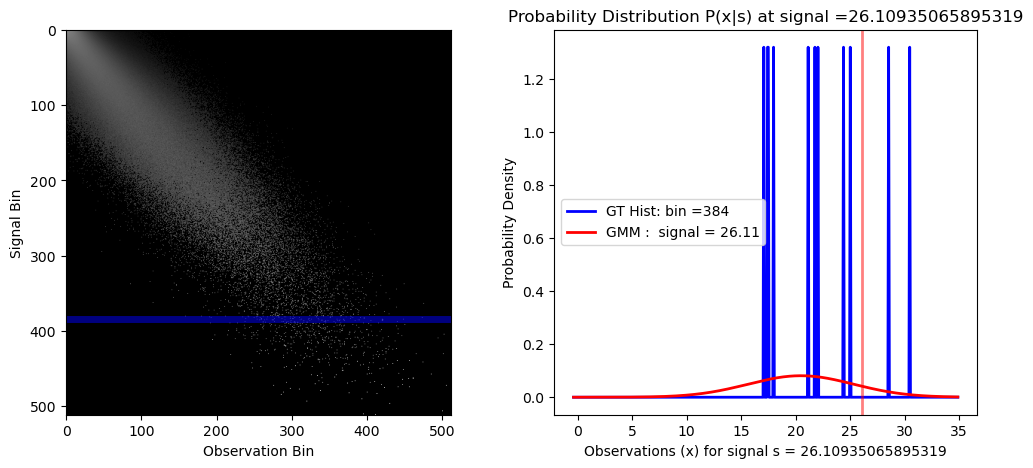

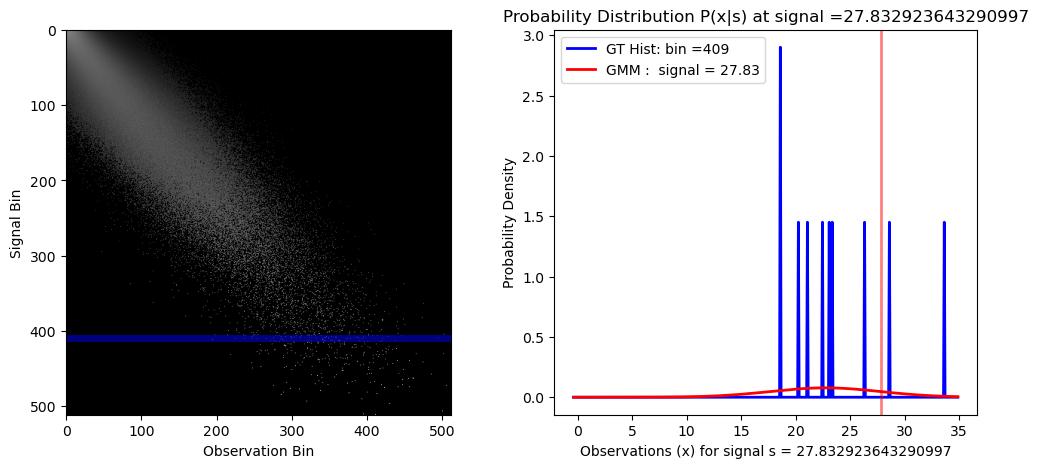

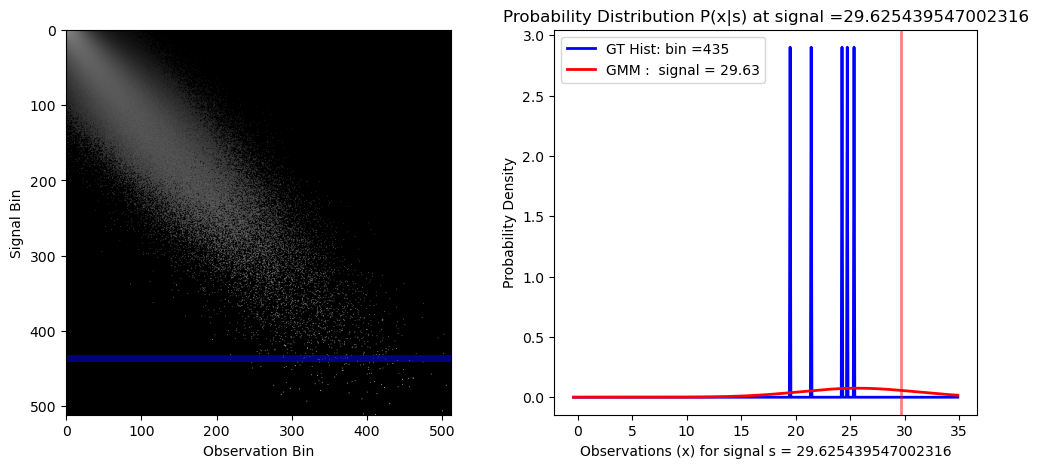

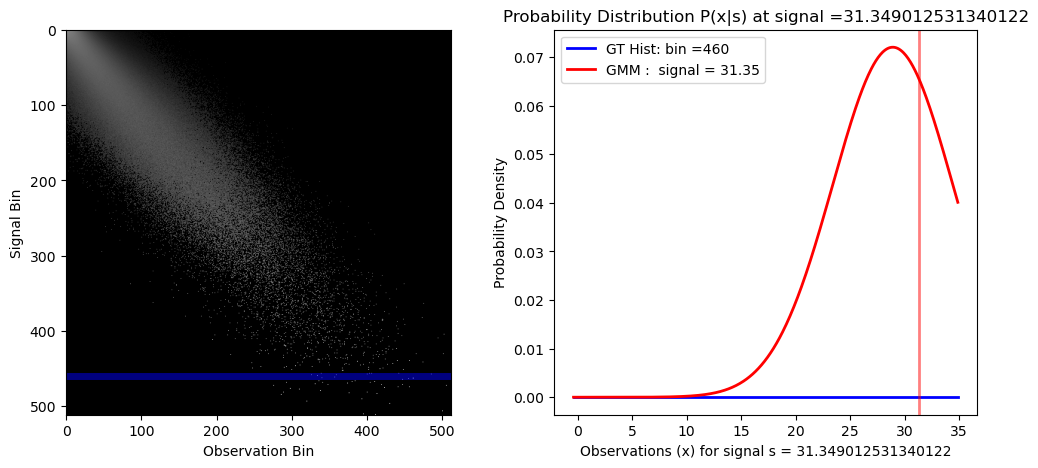

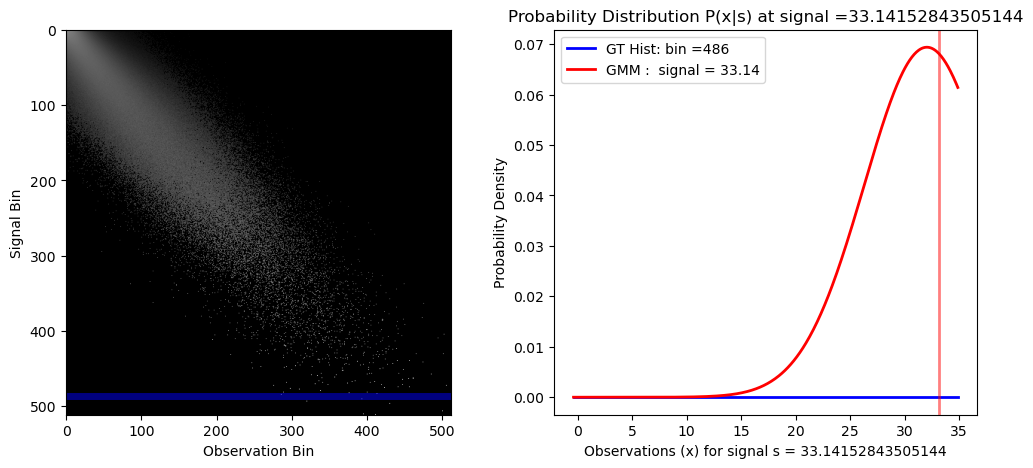

In [21]:
# Check GMM perf
GMMname = fullnameGMMNoiseModel[1::]+".npz" # to check current one
print(GMMname)
# GMMname = r"final_noReg/GMM_Noise0_SigN2V_Clip-3.npz"# to check existing one

n_points = 20
signalBinIndex_list = (np.linspace(0,n_points-1,n_points)*hist_bins//n_points).astype(int)
GMMmodel_prm = np.load(os.path.join(noiseModelsDir,GMMname))
GMMmodel = GaussianMixtureNoiseModel(params = GMMmodel_prm, device = device) 
# GMMmodel = gaussianMixtureNoiseModel
# GMMmodel.weight = torch.tensor([[ 1.8706, 0],
#         [-0.4762,  2.5608],
#         [ 0.9983, -1.9992]], device='cuda:0', requires_grad=True)


for binidx in signalBinIndex_list:
    plotProbabilityDistribution(signalBinIndex=binidx, histogram=histogram[0], gaussianMixtureNoiseModel=GMMmodel, min_signal=minValnorm, max_signal=maxValnorm, n_bin=hist_bins, device=device)